# Predicting flight delays

# Eksploracja danych

Celem projektu jest przeanalizowanie danych z biura U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics które śledzi terminowość lotów krajowych obsługiwanych przez dużych przewoźników lotniczych. Na podstawie przeanalizowanych danych chcęmy stworzyć model odpowiadający na pytanie: Którą linią lotniczą powinieneś polecieć, aby uniknąć znacznych opóźnień? Predykcja opóźnień lotów.

Zbiór daych zawiera podsumowanie informacji o liczbie lotów na czas, opóźnionych, odwołanych i przekierowanych. Informacja dotyczy roku 2015. Zbiór daych będzie pobrany ze strony: https://www.kaggle.com/usdot/flight-delays?fbclid=IwAR35RJkExG8_KySniI_W9RCrHTdkreTkNSuXfoiRBvpDhxuqT0ol4L-gjCk#flights.csv

Zbiór danych zawarty jest w trzech plikach csv: airlines.csv, airports.csv oraz flights.csv. Macierz zawarta w pliku airlines.csv zawiera jedynie dwie kolumny -- w pierwszej z nich przedstawiono identyfiaktor linii lotniczej, a w drugiej pełną nazwę tej linii. W pliku airports.csv przedstawiono informacje o pojawiających się w danych lotniskach -- mamy tu już do czynienia z siedmioma kolumnami, opisującymi podstawowe dane o portach lotniczych. Naszym głównym przedmiotem analizy będzie plik flights.csv, który w 31 kolumnach gromadzi dane o lotach.

In [1]:
import datetime, warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches


## Wczytanie danych

In [2]:
flights=pd.read_csv("flights.csv")

/home/knigawkl/envs/med/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Sprawdźmy obecne rozmiary ramki danych

In [3]:
flights.shape

(5819079, 31)

W zwiazku z tym, że pracujemy z tak wieloma kolumnami, polecenie head() biblioteki pandas nie pokazywałoby części środkowych kolumn. Z tego powodu wywołujemy poniższe polecenie.

In [4]:
pd.set_option('display.max_columns', None)

## Obcięcie danych 

Z powodu ilości danych utrudniającej szybką pracę na własnych maszynach roboczych, zdecydowano się na zmniejszenie objętości danych. W tym celu zdecydowano się na wzięcie z każdego dnia pierwszych 100000 rekordów.

In [5]:
flights=flights.groupby('DAY').head(10000).reset_index(drop=True)

## Wygląd uciętej ramki danych

In [6]:
flights.shape

(310000, 31)

Jak widać, ponad dwukrotnie zmniejszono liczbę rekordów w zbiorze.

Spójrzmy na ostatnie rekordy w ramce danych

In [7]:
flights.tail()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
309995,2015,1,31,6,US,409,N523UW,PHX,PDX,1755,1751.0,-4.0,19.0,1810.0,167.0,168.0,146.0,1009,1936.0,3.0,1942,1939.0,-3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
309996,2015,1,31,6,US,456,N604AW,PHX,SLC,1755,1746.0,-9.0,14.0,1800.0,97.0,97.0,76.0,507,1916.0,7.0,1932,1923.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
309997,2015,1,31,6,US,1718,N117UW,PHL,SJU,1755,1807.0,12.0,18.0,1825.0,237.0,223.0,197.0,1576,2242.0,8.0,2252,2250.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
309998,2015,1,31,6,US,1761,N631AW,DCA,PBI,1755,1752.0,-3.0,17.0,1809.0,157.0,144.0,123.0,857,2012.0,4.0,2032,2016.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
309999,2015,1,31,6,US,1876,N765US,DCA,MCO,1755,1745.0,-10.0,17.0,1802.0,149.0,132.0,110.0,759,1952.0,5.0,2024,1957.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Ostatnie pięć rekordów posiada puste wartości w tych samych kolumnach, co pierwsze pięć wierszy. Sprawdźmy, co opisują poszczególne kolumny. Zbiór danych na stronie Kaggle zawierał opis każdej z nich.

## Opis column 
YEAR -- Year of the Flight Trip

MONTH -- Month of the Flight Trip

DAY -- Day of the Flight Trip

DAY_OF_WEEK -- Day of week of the Flight Trip

AIRLINE -- Airline Identifier

FLIGHT_NUMBER -- Flight Identifier

TAIL_NUMBER -- Aircraft Identifier

ORIGIN_AIRPORT -- Starting Airport

DESTINATION_AIRPORT -- Destination Airport

SCHEDULED_DEPARTURE -- Planned Departure Time

DEPARTURE_TIME -- WHEEL_OFF - TAXI_OUT

DEPARTURE_DELAY -- Total Delay on Departure

TAXI_OUT -- The time duration elapsed between departure from the origin airport gate and wheels off

WHEELS_OFF -- The time point that the aircraft's wheels leave the ground

SCHEDULED_TIME -- Planned time amount needed for the flight trip

ELAPSED_TIME -- AIR_TIME+TAXI_IN+TAXI_OUT

AIR_TIME -- The time duration between wheels_off and wheels_on time

DISTANCE -- Distance between two airports

WHEELS_ON -- The time point that the aircraft's wheels touch on the ground

TAXI_IN -- The time duration elapsed between wheels-on and gate arrival at the destination airport

SCHEDULED_ARRIVAL -- Planned arrival time

ARRIVAL_TIME -- WHEELS_ON+TAXI_IN

ARRIVAL_DELAY -- ARRIVAL_TIME-SCHEDULED_ARRIVAL

DIVERTED -- Aircraft landed on airport that out of schedule

CANCELLED -- Flight Cancelled (1 = cancelled)

CANCELLATION_REASON -- Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security

AIR_SYSTEM_DELAY Delay -- caused by air system

SECURITY_DELAY Delay -- caused by security

AIRLINE_DELAY Delay -- caused by the airline

LATE_AIRCRAFT_DELAY -- Delay caused by aircraft

WEATHER_DELAY Delay -- caused by weather


Poniżej znajduje się pierwszy przegląd wszystkich atrybutów z uwzględnieniem typów danych

In [8]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310000 entries, 0 to 309999
Data columns (total 31 columns):
YEAR                   310000 non-null int64
MONTH                  310000 non-null int64
DAY                    310000 non-null int64
DAY_OF_WEEK            310000 non-null int64
AIRLINE                310000 non-null object
FLIGHT_NUMBER          310000 non-null int64
TAIL_NUMBER            308034 non-null object
ORIGIN_AIRPORT         310000 non-null object
DESTINATION_AIRPORT    310000 non-null object
SCHEDULED_DEPARTURE    310000 non-null int64
DEPARTURE_TIME         302580 non-null float64
DEPARTURE_DELAY        302580 non-null float64
TAXI_OUT               302452 non-null float64
WHEELS_OFF             302452 non-null float64
SCHEDULED_TIME         310000 non-null float64
ELAPSED_TIME           301724 non-null float64
AIR_TIME               301724 non-null float64
DISTANCE               310000 non-null int64
WHEELS_ON              302227 non-null float64
TAXI_IN       

Zwróćmy szczególną uwagę na kolumnę ARRIVAL_DELAY. Przedstawia ona różnicę między czasem przybyci, a planowym czasem przybycia. Przyjmuje więc wartości ujemne bądź dodatnie, gdyż pasażerowie mogli dotrzeć na lotnisko zarówno po czasie, jak i przed czasem. Wartości obecne w tej kolumnie możemy uznać za czas opóźnienia, czyli wartość, którą chcemy w przyszłości przewidywać.

## Zakresy wartości
Poniżej przedstawiono zwięzłe przedstawienie najbardziej podstawowych miar statystycznych zebranych dla poszczególnych kolumn, przed obróbką danych.

In [9]:
flights.loc[:,'AIRLINE':'WEATHER_DELAY'].describe()

,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,310000.000000,310000.000000,302580.000000,302580.000000,302452.000000,302452.000000,310000.000000,301724.000000,301724.000000,310000.000000,302227.000000,302227.000000,310000.000000,302227.000000,301724.000000,310000.000000,310000.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000
mean,2285.339639,1051.241990,1061.551365,7.558242,16.657410,1090.325390,141.244784,137.511143,113.298747,808.797958,1282.176437,7.561353,1289.178258,1294.646683,3.655924,0.002174,0.024523,14.616333,0.069959,19.833873,18.741363,3.028989
std,1806.908509,307.952162,319.838585,35.703152,9.685133,317.223467,73.520706,72.551878,70.617317,588.263569,347.178512,6.054132,337.959784,347.143810,38.491108,0.046578,0.154665,25.654848,2.079990,52.243125,40.163246,19.410304
min,1.000000,5.000000,1.000000,-48.000000,1.000000,2.000000,23.000000,17.000000,8.000000,31.000000,1.000000,1.000000,5.000000,1.000000,-76.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,774.000000,805.000000,810.000000,-5.000000,11.000000,828.000000,86.000000,84.000000,61.000000,370.000000,1014.000000,4.000000,1023.000000,1022.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1751.000000,1040.000000,1049.000000,-2.000000,14.000000,1105.000000,125.000000,121.000000,96.000000,650.000000,1259.000000,6.000000,1300.000000,1306.000000,-5.000000,0.000000,0.000000,6.000000,0.000000,2.000000,0.000000,0.000000
75%,3527.000000,1315.000000,1325.000000,5.000000,19.000000,1341.000000,175.000000,170.000000,145.000000,1055.000000,1539.000000,9.000000,1539.000000,1546.000000,8.000000,0.000000,0.000000,20.000000,0.000000,20.000000,22.000000,0.000000
max,9793.000000,1755.000000,2400.000000,1988.000000,176.000000,2400.000000,718.000000,724.000000,676.000000,4983.000000,2359.000000,174.000000,2359.000000,2400.000000,1971.000000,1.000000,1.000000,824.000000,237.000000,1971.000000,948.000000,938.000000


Sprawdźmy, jak wygląda heatmapa macierzy korelacji, przed preprocessingiem danych.

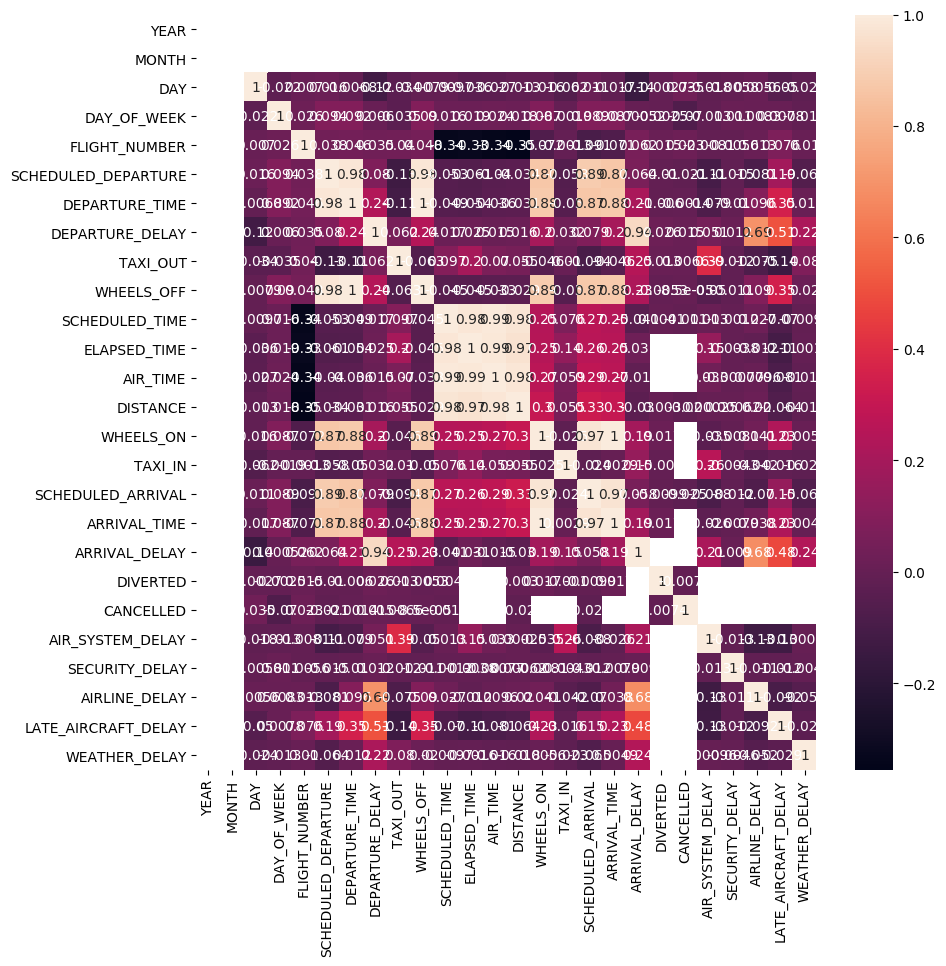

In [10]:
plt.figure(figsize=(10,10),dpi = 100)
cor = flights.corr(method='pearson')
sns.heatmap(cor, annot=cor)

Jest troszkę mocnych korelacji, mocniej przyjrzymy im sie po oczyszczeniu danych.

## Czyszczenie danych 



Dane w obecnej formie są obiektem trudnym do analizy. Aby umożliwić przeprowadzenie lepszych analiz, zdecydowano się na oczyszczenie zebranych danych, tak aby pozbyć się zbędnych elementów.

Po przekonwertowaniu niezbędnych wartości czasu na typ danych DateTime, trzeba sprawdzić dane zgodnie z ich integralnością. Wartości zerowe lub brakujące dane trzeba obsłużyć. Niżej jest zaprezentowana suma brakujących danych dla poszczególnych cech.

In [11]:
flights.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
FLIGHT_NUMBER               0
TAIL_NUMBER              1966
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME           7420
DEPARTURE_DELAY          7420
TAXI_OUT                 7548
WHEELS_OFF               7548
SCHEDULED_TIME              0
ELAPSED_TIME             8276
AIR_TIME                 8276
DISTANCE                    0
WHEELS_ON                7773
TAXI_IN                  7773
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME             7773
ARRIVAL_DELAY            8276
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON    302398
AIR_SYSTEM_DELAY       255325
SECURITY_DELAY         255325
AIRLINE_DELAY          255325
LATE_AIRCRAFT_DELAY    255325
WEATHER_DELAY          255325
dtype: int64

Analiza zerowa pokazuje które atrybuty posiadają najwęcej zerowych wartości:

* CANCELLATION_REASON
* AIR_SYSTEM_DELAY
* SECURITY_DELAY
* AIRLINE_DELAY
* LATE_AIRCRAFT_DELAY
* WEATHER_DELAY

Patrząc na dane, możemy zauważyć, że dane w kolumnach AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY są NaN, gdy nie wystąpiło opóźnienie (gdy chociaż w jednej z kolumn wystąpi dla danego rekordu opóźnienie, pozostałe przyjmują wartość nie NaN, a 0).
Można w tych kolumnach NaN przekształcić wartość na wartość 0.

In [12]:
flights['AIRLINE_DELAY'] = flights['AIRLINE_DELAY'].fillna(0)
flights['AIR_SYSTEM_DELAY'] = flights['AIR_SYSTEM_DELAY'].fillna(0)
flights['SECURITY_DELAY'] = flights['SECURITY_DELAY'].fillna(0)
flights['LATE_AIRCRAFT_DELAY'] = flights['LATE_AIRCRAFT_DELAY'].fillna(0)
flights['WEATHER_DELAY'] = flights['WEATHER_DELAY'].fillna(0)

In [13]:
flights.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
FLIGHT_NUMBER               0
TAIL_NUMBER              1966
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME           7420
DEPARTURE_DELAY          7420
TAXI_OUT                 7548
WHEELS_OFF               7548
SCHEDULED_TIME              0
ELAPSED_TIME             8276
AIR_TIME                 8276
DISTANCE                    0
WHEELS_ON                7773
TAXI_IN                  7773
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME             7773
ARRIVAL_DELAY            8276
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON    302398
AIR_SYSTEM_DELAY            0
SECURITY_DELAY              0
AIRLINE_DELAY               0
LATE_AIRCRAFT_DELAY         0
WEATHER_DELAY               0
dtype: int64

----------------

Wartości zerowe znacznie spadły. Zostało tylko kilka atrybutów. Szczególnie dużo zer jest jednak dla cechy CANCELLATION_REASON, prawie cała kolumna jest zerowa. Powód odwołania lotów dzieli się na następujące zdarzenia:
* A - Linia lotnicza / przewoźnik
* B - Pogoda
* C - National Air System
* D - Bezpieczeństwo

Poniżej są zaprezentowane liczności danych powodów odwolania lotu:

In [14]:
flights['CANCELLATION_REASON'].value_counts()

B    4412
A    1861
C    1329
Name: CANCELLATION_REASON, dtype: int64

Sprawdźmy, jaka część lotów została z jakiegokolwiek powodu anulowana


In [15]:
flights['CANCELLATION_REASON'].value_counts().sum() / flights.shape[0] * 100

2.452258064516129

Wynik w okolicach 1.5% wydaje się być bardzo prawdopodobny.

In [16]:
flights['CANCELLATION_REASON'].tail()

309995    NaN
309996    NaN
309997    NaN
309998    NaN
309999    NaN
Name: CANCELLATION_REASON, dtype: object

Zobaczmy jaka część z "przyciętych" danych dotyczy lotów anulowanych. Mamy do czynienia z kolumną wartości binarnych, gdzie 0 oznacza lot, który się odbył, a 1 oznacza lot, który został anulowany.

In [17]:
flights["CANCELLED"].value_counts()

0    302398
1      7602
Name: CANCELLED, dtype: int64

Sprawdźmy, jaka część lotów została anulowana

In [18]:
not_cancelled_count = flights["CANCELLED"].value_counts()[0]
cancelled_count = flights["CANCELLED"].value_counts()[1]
print(cancelled_count / (not_cancelled_count + cancelled_count) * 100)

2.452258064516129


Otrzymano taki sam wynik jak w przypadku poprzedniego obliczenia, w związku z czym dowiedzieliśmy się, że jeśli lot został anulowany, to na pewno podana została informacja o powodzie anulowania.

Widzimy więc, że zdecydowana większość lotów odbyła się (prędzej czy później). 

W związku z tym, usuniemy te wiersze, dla których kolumna CANCELLED przyjmowała niezerowe wartości, a potem usuniemy kolumny CANCELLED, CANCELLATION_REASON.

In [19]:
print(flights.shape[0])

310000


In [20]:
flights = flights[flights.CANCELLED == 0]

In [21]:
print(flights.shape[0])

302398


In [22]:
print(flights.shape[1])

31


In [23]:
flights = flights.drop('CANCELLED', 1)
flights = flights.drop('CANCELLATION_REASON', 1)

In [24]:
print(flights.shape[1])

29


------------------

Przypomnijmy sobie, jak wygląda nasza ramka danych.

In [25]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0.0,0.0,0.0,0.0,0.0


Sprawdźmy jak w tym momencie przedstawia się kwestia brakujących wartości.

In [26]:
flights.isnull().sum()

YEAR                     0
MONTH                    0
DAY                      0
DAY_OF_WEEK              0
AIRLINE                  0
FLIGHT_NUMBER            0
TAIL_NUMBER              0
ORIGIN_AIRPORT           0
DESTINATION_AIRPORT      0
SCHEDULED_DEPARTURE      0
DEPARTURE_TIME           0
DEPARTURE_DELAY          0
TAXI_OUT                 0
WHEELS_OFF               0
SCHEDULED_TIME           0
ELAPSED_TIME           674
AIR_TIME               674
DISTANCE                 0
WHEELS_ON              171
TAXI_IN                171
SCHEDULED_ARRIVAL        0
ARRIVAL_TIME           171
ARRIVAL_DELAY          674
DIVERTED                 0
AIR_SYSTEM_DELAY         0
SECURITY_DELAY           0
AIRLINE_DELAY            0
LATE_AIRCRAFT_DELAY      0
WEATHER_DELAY            0
dtype: int64

Jak obserwujemy, braki występują w przypadku sześciu różnych cech, aczkolwiek liczba braków dla danej cechy jest identyczna dla jednej połowy z nich, inna ale identyczna dla drugiej połowy. Zapiszmy obecną liczbę wierszy.

In [27]:
prev_row_count = flights.shape[0]

Poniższa instrukcja usuwa rekordy, w których znajduje się co najmniej jedna brakująca wartość. Jesteśmy w momencie, w którym chcemy się zdecydować na taką operację.

In [28]:
flights = flights.dropna()

In [29]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0.0,0.0,0.0,0.0,0.0


In [30]:
row_count = flights.shape[0]
removed_part = (prev_row_count - row_count) / prev_row_count * 100
#print(f'Usunięto {removed_part} procent wszystkich rekordów')

Usunięte dane stanowiły bardzo małą część całego zbioru.

In [31]:
flights.isnull().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64

-----------------------

Widoczny jest problem z atrybutami które repezentują czas. Czas w tych atrybutach jest zaprezentowany jako float64 oraz wygląda to przykładowo jako 843.0. Istnieje potrzeba przekonwertowania tego na godzinę.

In [32]:
# converting input time value to datetime.
def conv_time(time_val):
    if pd.isnull(time_val):
        return np.nan
    else:
            # replace 24:00 o'clock with 00:00 o'clock:
        if time_val == 2400: time_val = 0
            # creating a 4 digit value out of input value:
        time_val = "{0:04d}".format(int(time_val))
            # creating a time datatype out of input value: 
        time_formatted = datetime.time(int(time_val[0:2]), int(time_val[2:4]))
    return time_formatted

In [33]:
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(conv_time)
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(conv_time)
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply(conv_time)
flights['WHEELS_OFF'] = flights['WHEELS_OFF'].apply(conv_time)
flights['WHEELS_ON'] = flights['WHEELS_ON'].apply(conv_time)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(conv_time)

Teraz dane mają przyjaźniejszy format.

In [34]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,23:54:00,-11.0,21.0,00:15:00,205.0,194.0,169.0,1448,04:04:00,4.0,04:30:00,04:08:00,-22.0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,12.0,00:14:00,280.0,279.0,263.0,2330,07:37:00,4.0,07:50:00,07:41:00,-9.0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,16.0,00:34:00,286.0,293.0,266.0,2296,08:00:00,11.0,08:06:00,08:11:00,5.0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,15.0,00:30:00,285.0,281.0,258.0,2342,07:48:00,8.0,08:05:00,07:56:00,-9.0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,00:25:00,00:24:00,-1.0,11.0,00:35:00,235.0,215.0,199.0,1448,02:54:00,5.0,03:20:00,02:59:00,-21.0,0,0.0,0.0,0.0,0.0,0.0


------------------------

Teraz, gdy pozbyliśmy się braków w danych, czas zastanowić się, z których jeszcze kolumn możemy zrezygnować, gdyż nie wydają się być dobrą podstawą analizy.

In [35]:
flights.loc[:,'AIRLINE':'WEATHER_DELAY'].describe()

,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.0,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000
mean,2277.457133,7.500676,16.650797,141.355895,137.511143,113.298747,810.585416,7.561599,3.655924,0.0,2.648606,0.012677,3.594069,3.396097,0.548879
std,1806.337361,35.473149,9.673384,73.512622,72.551878,70.617317,588.377355,6.055378,38.491108,0.0,12.286677,0.885826,23.514688,18.558422,8.344604
min,1.000000,-48.000000,1.000000,23.000000,17.000000,8.000000,31.000000,1.000000,-76.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,770.000000,-5.000000,11.000000,87.000000,84.000000,61.000000,371.000000,4.000000,-13.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1741.000000,-2.000000,14.000000,125.000000,121.000000,96.000000,651.000000,6.000000,-5.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3498.250000,5.000000,19.000000,175.000000,170.000000,145.000000,1061.000000,9.000000,8.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,7438.000000,1988.000000,176.000000,718.000000,724.000000,676.000000,4983.000000,174.000000,1971.000000,0.0,824.000000,237.000000,1971.000000,948.000000,938.000000


Kolumna diverted opisuje sytuacje, w których samolot lądował na innym lądowisku, niż miał planowo. Całe szczęście, takich przypadków w naszym zbiorze nie zaobserwowaliśmy. A nawet gdybyśmy takie znaleźli, to byłyby to przypadki niesamowicie rzadkie. Możemy więc usunąć tę nieprzydatną kolumnę.

In [36]:
flights.shape[1]

29

In [37]:
flights = flights.drop('DIVERTED', 1)

In [38]:
flights.shape[1]

28

Ponownie przyjrzyjmy się statystykom, nie zaprzątając już sobie głowy usuniętą kolumną.

In [39]:
flights.loc[:,'AIRLINE':'WEATHER_DELAY'].describe()

,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000
mean,2277.457133,7.500676,16.650797,141.355895,137.511143,113.298747,810.585416,7.561599,3.655924,2.648606,0.012677,3.594069,3.396097,0.548879
std,1806.337361,35.473149,9.673384,73.512622,72.551878,70.617317,588.377355,6.055378,38.491108,12.286677,0.885826,23.514688,18.558422,8.344604
min,1.000000,-48.000000,1.000000,23.000000,17.000000,8.000000,31.000000,1.000000,-76.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,770.000000,-5.000000,11.000000,87.000000,84.000000,61.000000,371.000000,4.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1741.000000,-2.000000,14.000000,125.000000,121.000000,96.000000,651.000000,6.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3498.250000,5.000000,19.000000,175.000000,170.000000,145.000000,1061.000000,9.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7438.000000,1988.000000,176.000000,718.000000,724.000000,676.000000,4983.000000,174.000000,1971.000000,824.000000,237.000000,1971.000000,948.000000,938.000000


Kolejną kompletnie nieprzydatną kolumną jest FLIGHT_NUMBER. Jest to kolumna wartości numerycznych, które na pewno nie korelują z opóźnieniami lotów.

In [40]:
flights.shape[1]

28

In [41]:
flights = flights.drop('FLIGHT_NUMBER', 1)

In [42]:
flights.shape[1]

27

Ponownie przyjrzyjmy się statystykom, nie zaprzątając już sobie głowy usuniętą kolumną.

In [43]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,N407AS,ANC,SEA,00:05:00,23:54:00,-11.0,21.0,00:15:00,205.0,194.0,169.0,1448,04:04:00,4.0,04:30:00,04:08:00,-22.0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,12.0,00:14:00,280.0,279.0,263.0,2330,07:37:00,4.0,07:50:00,07:41:00,-9.0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,16.0,00:34:00,286.0,293.0,266.0,2296,08:00:00,11.0,08:06:00,08:11:00,5.0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,15.0,00:30:00,285.0,281.0,258.0,2342,07:48:00,8.0,08:05:00,07:56:00,-9.0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,N527AS,SEA,ANC,00:25:00,00:24:00,-1.0,11.0,00:35:00,235.0,215.0,199.0,1448,02:54:00,5.0,03:20:00,02:59:00,-21.0,0.0,0.0,0.0,0.0,0.0


In [44]:
flights.loc[:,'AIRLINE':'WEATHER_DELAY'].describe()

,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000,301724.000000
mean,7.500676,16.650797,141.355895,137.511143,113.298747,810.585416,7.561599,3.655924,2.648606,0.012677,3.594069,3.396097,0.548879
std,35.473149,9.673384,73.512622,72.551878,70.617317,588.377355,6.055378,38.491108,12.286677,0.885826,23.514688,18.558422,8.344604
min,-48.000000,1.000000,23.000000,17.000000,8.000000,31.000000,1.000000,-76.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.000000,11.000000,87.000000,84.000000,61.000000,371.000000,4.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.000000,14.000000,125.000000,121.000000,96.000000,651.000000,6.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,19.000000,175.000000,170.000000,145.000000,1061.000000,9.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1988.000000,176.000000,718.000000,724.000000,676.000000,4983.000000,174.000000,1971.000000,824.000000,237.000000,1971.000000,948.000000,938.000000


Najwyższa pora na analizę kolumn opisujących długość opóźnienia wynikająca z konkretnego powodu. Mamy 5 takich kolumn: WEATHER_DELAY, AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY.

Początkowo sprawdziliśmy, że w zbiorze dla 1963672 wierszy brakowało wartości w tych kolumnach. Oznacza to, że w prawie 82% przypadków nie posiadamy wiedzy na temat wartości w omawianych pięciu kolumnach. To że tych danych nie posiadamy, zdecydowanie nie oznacza, że wartości w tych miejscach byłyby zerowe (do czego wcześniej doprowadziliśmy poprzez zamianę NaN na 0). Wydaje się więc, że do analizy wystarczy nam wynikowa kolumna ARRIVAL_DELAY, w której braki były bardzo rzadkie, a wiersze je zawierające zostały usunięte.

In [45]:
flights.shape[1]

27

In [46]:
flights = flights.drop('WEATHER_DELAY', 1)
flights = flights.drop('AIR_SYSTEM_DELAY', 1)
flights = flights.drop('SECURITY_DELAY', 1)
flights = flights.drop('AIRLINE_DELAY', 1)
flights = flights.drop('LATE_AIRCRAFT_DELAY', 1)

In [47]:
flights.shape[1]

22

W tym momencie zredukowaliśmy już liczbę kolumn do 22 (z pierwotnych 31).

Przyjrzyjmy się teraz kolumnom opisującym czas. Przypomnijmy sobie ich opisy.

SCHEDULED_DEPARTURE -- Planned Departure Time

DEPARTURE_TIME -- WHEEL_OFF - TAXI_OUT

DEPARTURE_DELAY -- Total Delay on Departure

TAXI_OUT -- The time duration elapsed between departure from the origin airport gate and wheels off

WHEELS_OFF -- The time point that the aircraft's wheels leave the ground

SCHEDULED_TIME -- Planned time amount needed for the flight trip

ELAPSED_TIME -- AIR_TIME+TAXI_IN+TAXI_OUT

AIR_TIME -- The time duration between wheels_off and wheels_on time

WHEELS_ON -- The time point that the aircraft's wheels touch on the ground

TAXI_IN -- The time duration elapsed between wheels-on and gate arrival at the destination airport

SCHEDULED_ARRIVAL -- Planned arrival time

ARRIVAL_TIME -- WHEELS_ON+TAXI_IN

ARRIVAL_DELAY -- ARRIVAL_TIME-SCHEDULED_ARRIVAL

Szczególnie przyjrzyjmy się TAXI_OUT/IN oraz WHEELS_OFF/ON. Pierwsza para cech opisuje czas pomiędzy wyjściem przez bramkę lotniska a oderwaniem się od powierzchni lotniska kół samolotu oraz czas między momentem lądowania samolotu a przejściem przez bramki wejściowe lotniska. Druga para cech opisuje punkt w czasie w którym koła samolotu oderwały się od powierzchni lotniska / zetknęły się z powierzchnią lotniska. Wymienione cechy TAXI_OUT/IN oraz WHEELS_OFF/ON są już zawarte w innych cechach i nie chcemy zajmować się tymi konkretnymi.

In [48]:
flights.shape[1]

22

In [49]:
flights = flights.drop('TAXI_OUT', 1)
flights = flights.drop('TAXI_IN', 1)
flights = flights.drop('WHEELS_OFF', 1)
flights = flights.drop('WHEELS_ON', 1)

In [50]:
flights.shape[1]

18

Dane zdają się pochodzić w całości z roku 2015, sprawdźmy czy zaplątały się dane z innego roku.

In [51]:
flights['YEAR'].value_counts()

2015    301724
Name: YEAR, dtype: int64

Jak widać, wszystkie dane są z roku 2015, w związku z tym cecha YEAR nie przekazuje nam rzadnej informacji.

In [52]:
flights = flights.drop('YEAR', 1)
flights.shape[1]

17

Zostawimy jednak dane dotyczące miesiąca/dnia, gdyż na ich podstawie będziemy mogli poszukać ciekawych trendów (może opóźnienia są większe zimą?).

In [53]:
flights.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,N407AS,ANC,SEA,00:05:00,23:54:00,-11.0,205.0,194.0,169.0,1448,04:30:00,04:08:00,-22.0
1,1,1,4,AA,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,280.0,279.0,263.0,2330,07:50:00,07:41:00,-9.0
2,1,1,4,US,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,286.0,293.0,266.0,2296,08:06:00,08:11:00,5.0
3,1,1,4,AA,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,285.0,281.0,258.0,2342,08:05:00,07:56:00,-9.0
4,1,1,4,AS,N527AS,SEA,ANC,00:25:00,00:24:00,-1.0,235.0,215.0,199.0,1448,03:20:00,02:59:00,-21.0


W tym momencie w zbiorze znajdują się dwie cechy opisujące opóźnienia - DEPARTURE_DELAY oraz ARRIVAL_DELAY. Pierwsza z nich opisuje opóźnienie przed odlotem, a druga opisuje opóźnienie po przylocie. Są to dwie zdecydowanie różne wartości, założyliśmy, że chcemy przewidywać ARRIVAL_DELAY, znając DEPARTURE_DELAY -- co oczywiście wydaje się być znacznym ułatwieniem, gdyż (co sprawdzimy przy analizie korelacji) najprawdopodobniej zmienne te mocno korelują ze sobą. Należy jednak zauważyć, że lot opóźniony przy odlocie może być potem na czas, gdyż samolot może nadrobić opóźnienie w locie, a także lot bez opóźnień przy odlocie może z jakiegoś powodu, chociażby poprzez tłok na lotnisku, zostać opóźniony później.

Zbadajmy kolumnę TAIL_NUMBER. Odnosi się ona do numeru konkretnego samolotu, w numerze tym znajduje się informacja o linii lotniczej (którą przechowujemy już w innej kolumnie).

In [54]:
flights['TAIL_NUMBER'].value_counts()

N484HA    244
N475HA    243
N491HA    241
N476HA    237
N485HA    236
         ... 
N1602       1
N7BKAA      1
N652UA      1
N78004      1
N780UA      1
Name: TAIL_NUMBER, Length: 4385, dtype: int64

In [55]:
flights['TAIL_NUMBER'].nunique()

4385

Jak widzimy, niektóre samoloty pojawiają się w naszym zbiorze tysiące razy, a niektóre jedynie jednokrotnie. Na ten moment ciężko powiedzieć, czy jakieś samoloty mogą mieć skłonności do opóźnień, ale na razie nie usuwajmy tej kolumny. Możliwe, że niektore samoloty latają na dłuższych dystansach, co da nam prawdopodobnie większe szanse na dłuższe opóźnienia.

Sprawdźmy, z ilu różnych lotnisk wyruszały loty

In [56]:
flights['ORIGIN_AIRPORT'].nunique()

310

Sprawdźmy, do ilu różnych lotnisk odbywały się loty

In [57]:
flights['DESTINATION_AIRPORT'].nunique()

307

Co ciekawe, więcej jest różnych unikatowych wartości w kolumnie ORIGIN_AIRPORT niż dla cechy DESTINATION_AIRPORT.

Sprawdźmy, czy na pewno mamy dane z każdego miesiąca...

In [58]:
flights['MONTH'].nunique()

1

...i dnia

In [59]:
flights['DAY'].nunique()

31

Wszystko pod kontrolą, w tym momencie przypominamy sobie, że jeśli pracujemy na obciętych danych, to mamy dane nie z każdego dnia miesiąca

In [60]:
flights['DAY'].value_counts()

17    9965
16    9950
19    9942
23    9934
30    9916
15    9912
20    9910
29    9906
22    9904
21    9893
18    9887
31    9879
25    9877
14    9849
13    9840
2     9833
7     9825
10    9815
5     9804
11    9798
24    9792
4     9764
3     9756
12    9665
9     9650
6     9650
8     9593
1     9593
26    9362
28    9300
27    7960
Name: DAY, dtype: int64

------------------------

## Dodanie lotnisk do analizy

Następnym krokiem analizy jest dodanie lokalizacji do danych. Chcemy uwzględnić lotniska i spróbować dowiedzieć się, czy ma to wpływ na opóźnienie. Aby to zrobić dodamy dane z innego pliku który zawiera wszystkie lotniska.


In [61]:
airlines = pd.read_csv('airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [62]:
flights = flights.merge(airlines, left_on='AIRLINE', right_on='IATA_CODE', how='inner')

In [63]:
flights = flights.drop(['AIRLINE_x','IATA_CODE'], axis=1)
flights = flights.rename(columns={"AIRLINE_y":"AIRLINE"})

In [64]:
flights.head()

,MONTH,DAY,DAY_OF_WEEK,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIRLINE
0,1,1,4,N407AS,ANC,SEA,00:05:00,23:54:00,-11.0,205.0,194.0,169.0,1448,04:30:00,04:08:00,-22.0,Alaska Airlines Inc.
1,1,1,4,N527AS,SEA,ANC,00:25:00,00:24:00,-1.0,235.0,215.0,199.0,1448,03:20:00,02:59:00,-21.0,Alaska Airlines Inc.
2,1,1,4,N309AS,ANC,SEA,00:45:00,00:41:00,-4.0,204.0,194.0,173.0,1448,05:09:00,04:55:00,-14.0,Alaska Airlines Inc.
3,1,1,4,N413AS,ANC,PDX,00:50:00,00:46:00,-4.0,215.0,201.0,187.0,1542,05:25:00,05:07:00,-18.0,Alaska Airlines Inc.
4,1,1,4,N457AS,FAI,SEA,01:15:00,01:07:00,-8.0,213.0,218.0,186.0,1533,05:48:00,05:45:00,-3.0,Alaska Airlines Inc.


-----------------

# Wizualizacje

## Opóźnienia w zbiorze

Przyjrzyjmy się opóźnieniom w zbiorze przedstawionym w bardziej obrazowy sposób.

In [65]:
flights['ARRIVAL_DELAY'].describe()

count    301724.000000
mean          3.655924
std          38.491108
min         -76.000000
25%         -13.000000
50%          -5.000000
75%           8.000000
max        1971.000000
Name: ARRIVAL_DELAY, dtype: float64

Powyżej przedstawiono podstawowe miary statystyczne dla naszej kolumny wynikowej. Wartości przedstawione sa w minutach. Jeśli wartości są ujemne, oznacza to, że pasażerowie dotarli na miejsce przed czasem. Średnio jednak pasażerowie docierali z niewielkim opóźnieniem.

In [66]:
delayed = flights[flights['ARRIVAL_DELAY']>0]
print("Lotów opóźnionych było %.2f"%(delayed.shape[0]*100/flights.shape[0]))
on_time = flights[flights['ARRIVAL_DELAY']==0]
print("Lotów co do minuty na czas było %.2f"%(on_time.shape[0]*100/flights.shape[0]))
advanced = flights[flights['ARRIVAL_DELAY']<0]
print("Lotów które zostały zakończone przed czasem było %.2f"%(advanced.shape[0]*100/flights.shape[0]))

Lotów opóźnionych było 37.05
Lotów co do minuty na czas było 2.27
Lotów które zostały zakończone przed czasem było 60.67


Text(0.5, 1.0, 'ARRIVAL_DELAY')

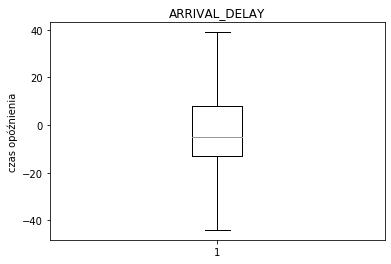

In [67]:
plt.boxplot(flights.loc[:, ['ARRIVAL_DELAY']].dropna().T, showfliers=False)
plt.ylabel('czas opóźnienia')
plt.title('ARRIVAL_DELAY')

Text(0.5, 1.0, 'ARRIVAL_DELAY')

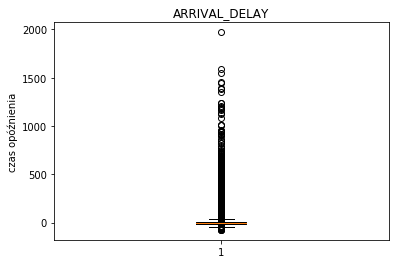

In [68]:
plt.boxplot(flights.loc[:, ['ARRIVAL_DELAY']].dropna().T, showfliers=True)
plt.ylabel('czas opóźnienia')
plt.title('ARRIVAL_DELAY')

Warto zauważyć oczywiste zależności: pomimo iż większość lotów jest nieznacznie przed czasem, to odchylenia od zera w stronę ujemną są niewielkie. Znacznie większe odchylenia mogą pojawiać się dla lotów opóźnionych.

-----------------

# Sezonowość i trendy okresowe

Ciekawą kwestią wydaje się być sprawdzenie sezonowości opóźnień w zależności od miesiąca/dnia tygodnia/dnia miesiąca.

Sprawdźmy czy w zależności od miesiąca zmieniają się średnie długości opóźnień

Text(0.5, 0, 'Minuty opóźnienia')

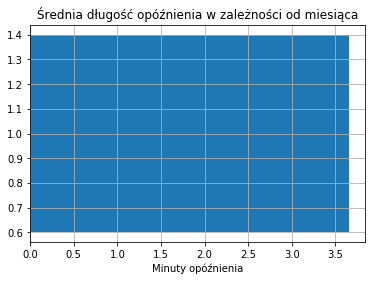

In [69]:
grouped_by_month = flights.loc[:,['ARRIVAL_DELAY','MONTH']].groupby(['MONTH']).mean()
ax1 = plt.barh(grouped_by_month.index, grouped_by_month['ARRIVAL_DELAY'])
ax1 = plt.title('Średnia długość opóźnienia w zależności od miesiąca')
ax1 = plt.grid(True)
plt.xlabel('Minuty opóźnienia')

Wygląda na to, że w styczniu mamy do czynienia z największymi opóźnieniami. Da się to wytłumaczyć niesprzyjającymi warunkami atmosferycznymi.

Sprawdźmy średnie opóźnienie w zależności od dnia miesiąca. Nie spodziewam się różnic pomiędzy dniami, ale zobaczmy.

Text(0.5, 0, 'Minuty opóźnienia')

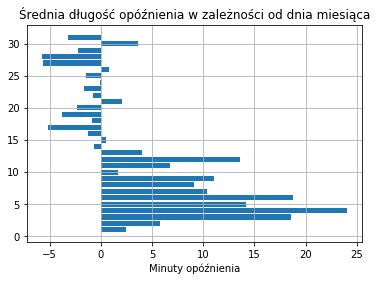

In [70]:
grouped_by_day = flights.loc[:,['ARRIVAL_DELAY','DAY']].groupby(['DAY']).mean()
ax1 = plt.barh(grouped_by_day.index, grouped_by_day['ARRIVAL_DELAY'])
ax1 = plt.title('Średnia długość opóźnienia w zależności od dnia miesiąca')
ax1 = plt.grid(True)
plt.xlabel('Minuty opóźnienia')

Wyniki są naprawdę zastanawiające. Grupowanie po dniu miesiąca zdaje się jednak mieć mniej sensu, niż grupowanie po dniu tygodnia. Na szczęście mamy także i cechę opisującą dzień tygodnia.

Text(0.5, 0, 'Minuty opóźnienia')

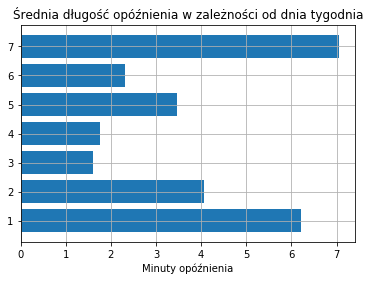

In [71]:
grouped_by_day_of_week = flights.loc[:,['ARRIVAL_DELAY','DAY_OF_WEEK']].groupby(['DAY_OF_WEEK']).mean()
ax1 = plt.barh(grouped_by_day_of_week.index, grouped_by_day_of_week['ARRIVAL_DELAY'])
ax1 = plt.title('Średnia długość opóźnienia w zależności od dnia tygodnia')
ax1 = plt.grid(True)
plt.xlabel('Minuty opóźnienia')

Ciekawe, że w naszym zbiorze ewidentnie najmniejsze opóźnienia (ba, średnio osiągające wartości ujemne) obserwujemy dla szóstego dnia tygodnia

----------------

Sprawdźmy jak przedstawia się liczba lotów w naszej bazie w zależności od dnia tygodnia, miesiąca.

In [72]:
flights["MONTH"].value_counts()

1    301724
Name: MONTH, dtype: int64

W tym momencie przypominamy sobie, że ograniczyliśmy zbiór i dla każdego miesiąca posiadamy po 200000 obserwacji.

In [73]:
flights["DAY"].value_counts()

17    9965
16    9950
19    9942
23    9934
30    9916
15    9912
20    9910
29    9906
22    9904
21    9893
18    9887
31    9879
25    9877
14    9849
13    9840
2     9833
7     9825
10    9815
5     9804
11    9798
24    9792
4     9764
3     9756
12    9665
9     9650
6     9650
8     9593
1     9593
26    9362
28    9300
27    7960
Name: DAY, dtype: int64

Sprawdzając tę statystykę dla konkretnego dnia możemy odnaleźć wyjaśnienie mocnego odchylenia czternastego dnia miesiąca od pozostałych na wykresie 'Średnia długość opóźnienia w zależności od dnia miesiąca'. Danych z czternastego dnia miesiąca było po prostu niewiele, zauważalnie mniej danych wzieliśmy też z trzynastego dnia.

Na ten moment wydaje się, że kolumna informująca nas o konkretnym dniu miesiąca jest nam niepotrzebna - trendy okresowe zaobserwujemy dla cechy określającej który to dzień tygodnia, a to jaki dzień tygodnia przypada w dany dzień miesiąca jest zmienne. Oczywiście mogłoby się okazać że mamy do czynienia z ciekawą zależnością polegającą na tym, że opóźnienia, dajmy na to, są znaczne pod koniec miesiąca. Jest to jednak bardzo mało prawdopodobne, a w związku z tym że dla niektórych dni posiadamy nieproporcjonalnie mało danych, nasz model mógłby dla nich nauczyć się nierealnych zależności. Podsumowując, rezygnujemy z kolumny DAY.

In [74]:
flights.shape[1]

17

In [75]:
flights = flights.drop('DAY', 1)

In [76]:
flights.shape[1]

16

W końcu zobaczmy, jak prezentuje się liczba lotów w zależności od dnia tygodnia. Tutaj spodziewamy się już zauważalnej różnicy między dniami pracy a weekendami.

In [77]:
flights["DAY_OF_WEEK"].value_counts()

5    49283
6    49207
4    48908
7    39326
3    38867
1    38773
2    37360
Name: DAY_OF_WEEK, dtype: int64

/home/knigawkl/envs/med/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


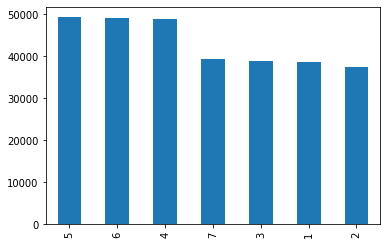

In [78]:
flights["DAY_OF_WEEK"].value_counts().plot('bar')

Zauważamy, że najwięcej lotów odbywa się czwartego i piątego dnia tygodnia, a najmniej szóstego. Z perspektywy modelu nie ma większego znaczenia, czy 7 oznacza niedzielę, ale nie udało nam się znaleźć informacji o tym, który dzień jest oznaczony w jaki sposób. Najprawdopodobniej 6 oznacza sobotę, w tej sytuacji wytłumaczalne byłoby to, iż jest wtedy mniej lotów (a najwięcej w czwartek, piątek i niedzielę). Pewna obserwacja jest tylko taka, iż jednego z dni tygodnia występuje zauważalny spadek liczby lotów.

------------

## Analiza lotów w zależności od firmy

Sprawdźmy, jakich linii najwięcej lotów zarejestrowano w naszym zbiorze

In [79]:
flights['AIRLINE'].value_counts()

Southwest Airlines Co.          63958
Delta Air Lines Inc.            42550
Atlantic Southeast Airlines     32280
Skywest Airlines Inc.           31201
American Airlines Inc.          28646
United Air Lines Inc.           25243
US Airways Inc.                 21390
American Eagle Airlines Inc.    18616
JetBlue Airways                 12836
Alaska Airlines Inc.             8450
Spirit Air Lines                 5235
Hawaiian Airlines Inc.           4350
Frontier Airlines Inc.           4043
Virgin America                   2926
Name: AIRLINE, dtype: int64

Sprawdźmy, jaka część danych dotyczy lotów daną linią.

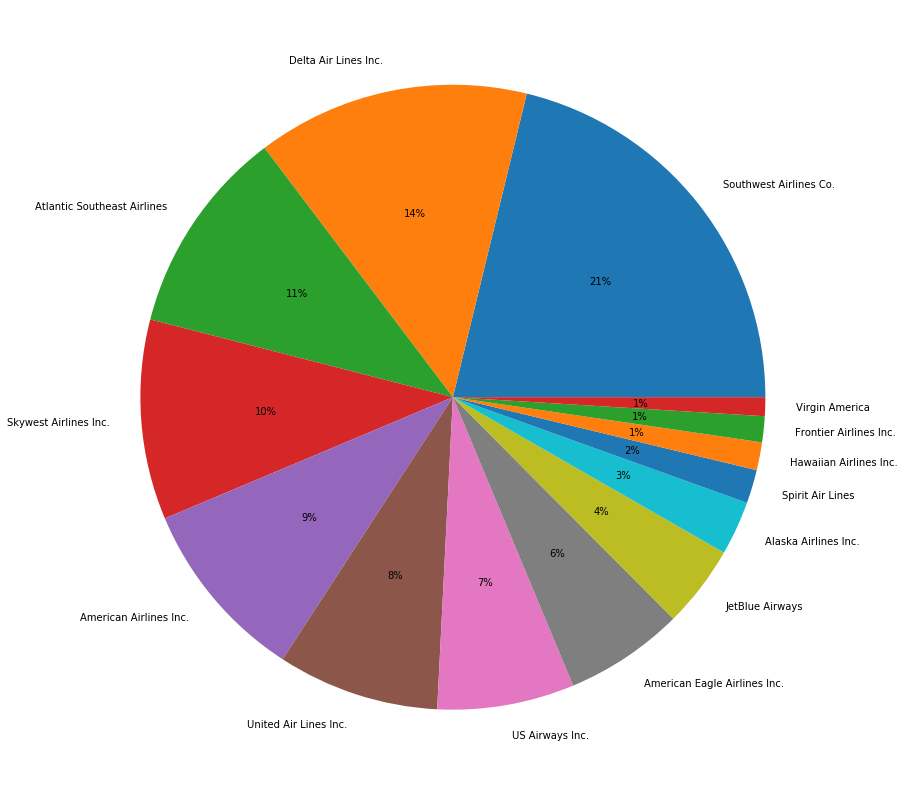

In [80]:
fig_dim = (14,18)
f, ax = plt.subplots(figsize=fig_dim)
quality=flights["AIRLINE"].value_counts().keys().tolist()
size=flights["AIRLINE"].value_counts()

plt.pie(size,labels=quality,autopct='%1.0f%%')
plt.show()

Jak możemy zaobserwować na powyższym diagramie, dwucyfrowe udziały w liczbie lotów w omawianym zbiorze posiada 5 linii, i są to Southwest Airlines (22%), Delta Air Lines (15%), American Airways (12%) oraz Skywest Lines i Atlantic Southeast Lines (obie po 10%.)

## Analiza opóźnień w zależnosci od firmy

Poniższy wykres prezentuje liczbę opóźnionych lotów danych linii lotniczych.

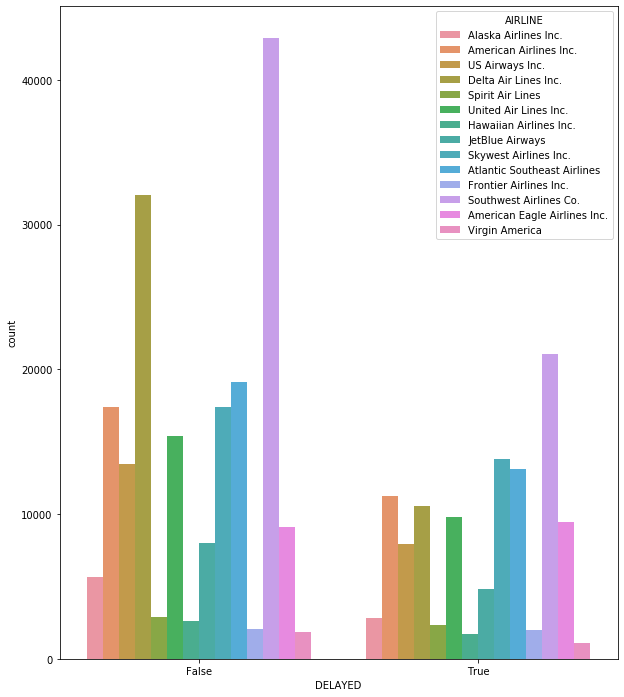

In [81]:
flights['DELAYED'] = flights.loc[:,'ARRIVAL_DELAY'].values > 0
figsize=plt.subplots(figsize=(10,12))
sns.countplot(x='DELAYED',hue='AIRLINE',data=flights)
plt.show()

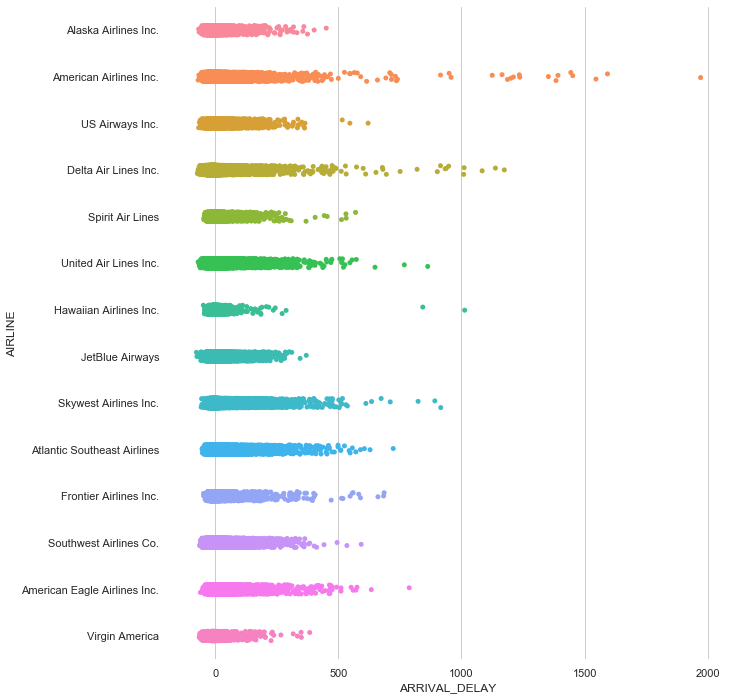

In [82]:
sns.set(style="whitegrid")

fig_dim = (10,12)
f, ax = plt.subplots(figsize=fig_dim)
sns.despine(bottom=True, left=True)

sns.stripplot(x="ARRIVAL_DELAY", y="AIRLINE", data=flights, dodge=True, jitter=True)
plt.show()

Powyższa dystrybucja pokazuje linie lotnicze w porównaniu do ich ARRIVAL_DELAY. To wyraźnie pokazuje, że American Airlines ma szeroki zakres opóźnień. Zwróćmy uwagę na fakt, iż linie lotnicze są posortowane po liczbie lotów przedstawionych w zbiorze, czyli linie znajdujące się na wykresie wyżej, mają w zbiorze więcej dotyczących ich wierszy. Już na pierwszy rzut oka na naganę zasługują oprócz American Airlines także Delta Air Lines.

Należy jednak na podstawie tego wykresu nie wyciągać dalekoidących wniosków, gdyż bardzo możliwe że część linii specjalizuje się w krótkich lotach, a część w długich -- najprawdopodobniej im dłuższa trasa, tym większa szansa na opóźnienia. Sprawdzimy tę hipotezę przy analizie korelacji.

-----------------

## Korelacja cech

Głównym celem jest zidentyfikowanie cech wpływających na ARRIVAL_DELAY w pozytywny lub negatywny sposób.

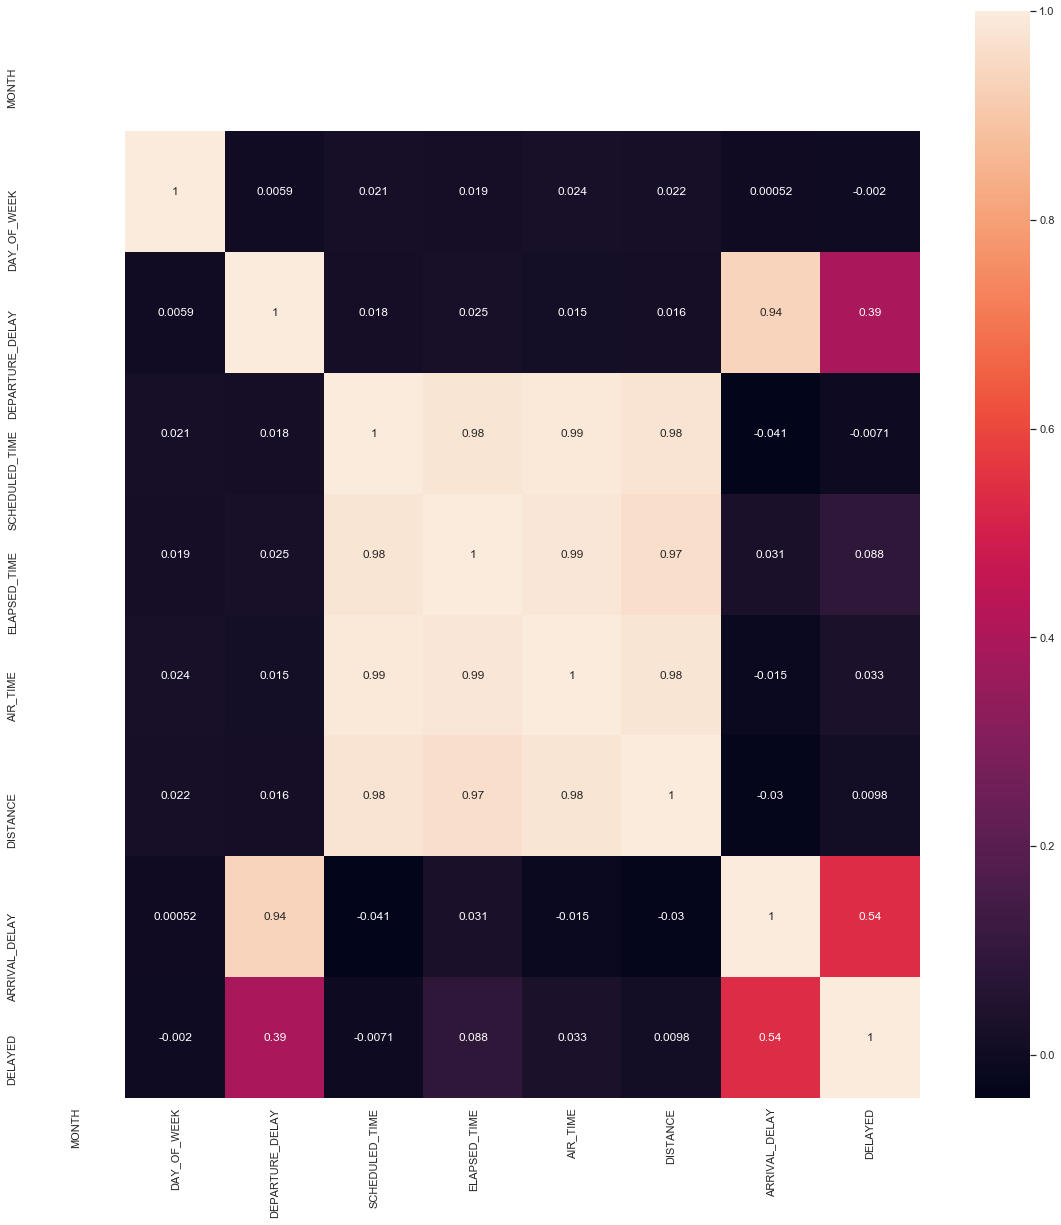

In [83]:
del_corr =flights.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(del_corr,annot=True)
plt.show()

Jak widzimy, na wykresie możemy zaobserwować kilka mocnych korelacji. Z naszą cechą wynikową koreluje najmocniej cecha DEPARTURE_DELAY - jest to dość oczywiste, że opóźnienie przed odlotem ma silną korelację z opóźnieniem po przylocie.

Pozostałe mocne korelacje są dość oczywiste - im większy dystans, tym dłuższy lot, a samolot dłużej znajduje się wtedy w powietrzu.

Jasne wydaje się także to, że nie obserwujemy korelacji liniowej między miesiącem/dniem tygodnia a długością opóźnienia, ale postaramy się tutaj wyszukać jakieś nieliniowe zazleżności.

# Wnioski

Wiele pomniejszych wniosków i rozważań umieszczono powyżej. W tym miejscu skupimy się na podsumowaniu analizy eksploracyjnej.

* Prawdopodobnie lepsze wyniki model osiągnie, gdy wykorzystamy cały posiadany zbiór danych. Jednak aby ułatwić sobie analizę eksploracyjną, zdecydowano się na zredukowanie liczby wierszy w zbiorze i na takim zbiorze danych będą przeprowadzane prace nad zbudowaniem modelu regresji.
* Zdecydowano się na zrezygnowanie z wzięcia pod uwagę przy dalszej pracy wielu cech, gdyż wydawały się one nieprzydatne lub były zawarte w innych cechach. Możliwe, że podczas dalszej pracy nad projektem, zmieni się jeszcze struktura danych (to znaczy możliwe, że niektóre cechy powrócą, a niektóre z nadal obecnych zostaną usunięte).
* Przedstawienie niektórych informacji na wykresach różnego typu daje łatwiejszy do zrozumienia obraz problemu niż tylko przedstawienie miar statystycznych.
* Analiza liniowych korelacji między cechami nie przyniosła zbyt wielu wniosków. W ramce danych znajduje się kilka cech bardzo silnie korelujących, które na dalszym etapie projektu możliwe że zostaną połączone w jedną cechę.
* Wybrany temat projektu wydaje się być ciekawy, a przy realizacji projektu możemy poszerzyć swoją wiedzę także z zakresu znajomości branżyu lotniczej. Jedną z poznanych ciekawostek jest fakt, iż w soboty odbywa się najmniej lotów (najpierw taka obserwacja wyniknęła z wykresu, potem sprawdzono w internecie, że jest to prawdziwe zjawisko).

# Hipoteza badawcza

Na podstawie przeprowadzonej analizy eksploracyjnej możemy wysnuć hipotezę mówiącą, że na podstawie  bazowych danych dotyczących lotu, a w tym informacji o opóźnieniu przed odlotem, można oszacować długość ostatecznego opóźnienia lotu (w tym jego brak lub ujemną wartość charakterystyczną dla lotów zrealizowanych przed planowym czasem przylotu), a znajomość  wyników takiej predykcji dla różnych linii samolotowych może pomóc w wyborze linii lotniczej.

### Zapisanie ramki danych do pliku csv

In [85]:
flights.to_csv("flights_explored_small.csv",encoding='utf-8',index=False)